# Data Gathering

In [ ]:
#!pip install yfinance
#!pip install xgboost
import time
import numpy as np

import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#!pip install yfinance
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'GOOGL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-1-1')

# See your data
print(tickerDf)


                                Open       High        Low      Close  \
Date                                                                    
2010-01-04 00:00:00-05:00  15.689439  15.753504  15.621622  15.684434   
2010-01-05 00:00:00-05:00  15.695195  15.711712  15.554054  15.615365   
2010-01-06 00:00:00-05:00  15.662162  15.662162  15.174174  15.221722   
2010-01-07 00:00:00-05:00  15.250250  15.265265  14.831081  14.867367   
2010-01-08 00:00:00-05:00  14.814815  15.096346  14.742492  15.065566   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00-05:00  87.110001  89.550003  87.070000  89.230003   
2022-12-27 00:00:00-05:00  88.800003  88.940002  87.010002  87.389999   
2022-12-28 00:00:00-05:00  86.980003  88.040001  85.940002  86.019997   
2022-12-29 00:00:00-05:00  86.620003  88.849998  86.610001  88.449997   
2022-12-30 00:00:00-05:00  86.980003  88.300003  86.570000  88.230003   

                              Volume  Dividends  S

In [ ]:
tickerDf.head(7)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,15.689439,15.753504,15.621622,15.684434,78169752,0.0,0.0
2010-01-05 00:00:00-05:00,15.695195,15.711712,15.554054,15.615365,120067812,0.0,0.0
2010-01-06 00:00:00-05:00,15.662162,15.662162,15.174174,15.221722,158988852,0.0,0.0
2010-01-07 00:00:00-05:00,15.250250,15.265265,14.831081,14.867367,256315428,0.0,0.0
2010-01-08 00:00:00-05:00,14.814815,15.096346,14.742492,15.065566,188783028,0.0,0.0
2010-01-11 00:00:00-05:00,15.126627,15.126627,14.865866,15.042793,288227484,0.0,0.0
2010-01-12 00:00:00-05:00,14.956206,14.968969,14.714715,14.776777,193937868,0.0,0.0


# Data Cleaning

In [ ]:
tickerDf[tickerDf['Stock Splits'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-04-03 00:00:00-04:00,28.669500,29.415001,28.300501,28.575001,80366000,0.0,1.998
2022-07-18 00:00:00-04:00,112.639999,113.680000,108.370003,109.029999,43164600,0.0,20.000


In [ ]:
tickerDf.applymap(lambda x: x == 0).sum()

Open               0
High               0
Low                0
Close              0
Volume             0
Dividends       3272
Stock Splits    3270
dtype: int64

**Removal of Dividends and stock split columns**

The dividends stock split column contain mostly zero as no dividents have been paid out over this timeframe and there has only been two stock split in the same timeframe.

They do not provide any meaningful information for the analysis.

In [ ]:
tickerDf.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [ ]:
tickerDf.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,15.689439,15.753504,15.621622,15.684434,78169752
2010-01-05 00:00:00-05:00,15.695195,15.711712,15.554054,15.615365,120067812
2010-01-06 00:00:00-05:00,15.662162,15.662162,15.174174,15.221722,158988852
2010-01-07 00:00:00-05:00,15.250250,15.265265,14.831081,14.867367,256315428
2010-01-08 00:00:00-05:00,14.814815,15.096346,14.742492,15.065566,188783028


In [ ]:
tickerDf_reset = tickerDf.reset_index()

tickerDf_reset['Date'] = pd.to_datetime(tickerDf_reset['Date']).dt.date

# Display the Date and Close columns
tickerDf_reset.head(3)


,Date,Open,High,Low,Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852


In [ ]:
print('There are {} number of days in the dataset.'.format(tickerDf_reset.shape[0]))

There are 3272 number of days in the dataset.


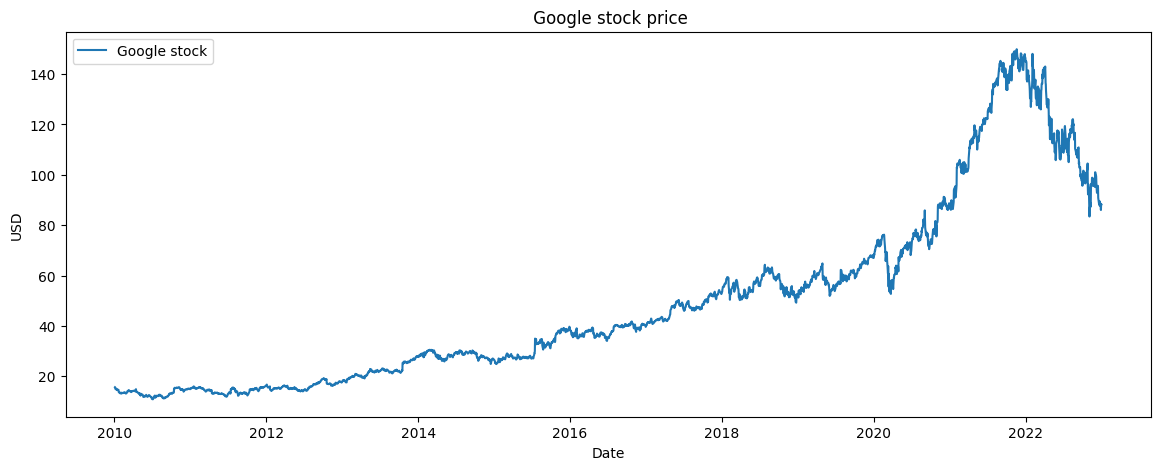

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(tickerDf_reset['Date'], tickerDf_reset['Close'], label='Google stock')
#plt.vlines(datetime.date(2019,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title(' Google stock price')
plt.legend()
plt.show()

# Correlated Assets

In [ ]:
tickerSymbols = ['AAPL', 'MSFT', 'AMZN']  # Use 'FB' for Meta Platforms, as 'META' is a recent change

# Get historical prices for these tickers
tickerDfCor = yf.download(tickerSymbols, start='2010-1-1', end='2023-1-1', group_by='ticker')

# See your data
print(tickerDfCor)

[*********************100%%**********************]  3 of 3 completed

Ticker           AMZN                                                         \
Price            Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2010-01-04   6.812500   6.830500   6.657000   6.695000   6.695000  151998000   
2010-01-05   6.671500   6.774000   6.590500   6.734500   6.734500  177038000   
2010-01-06   6.730000   6.736500   6.582500   6.612500   6.612500  143576000   
2010-01-07   6.600500   6.616000   6.440000   6.500000   6.500000  220604000   
2010-01-08   6.528000   6.684000   6.451500   6.676000   6.676000  196610000   
...               ...        ...        ...        ...        ...        ...   
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700   
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000   
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600   
2022-12-29  82.870003  84.550003  82.550

In [ ]:
close_prices = pd.DataFrame()

for ticker in tickerSymbols:
    close_prices[ticker] = tickerDfCor[ticker]['Close']

# Display the consolidated closing prices DataFrame
print(close_prices)

                  AAPL        MSFT       AMZN
Date                                         
2010-01-04    7.643214   30.950001   6.695000
2010-01-05    7.656429   30.959999   6.734500
2010-01-06    7.534643   30.770000   6.612500
2010-01-07    7.520714   30.450001   6.500000
2010-01-08    7.570714   30.660000   6.676000
...                ...         ...        ...
2022-12-23  131.860001  238.729996  85.250000
2022-12-27  130.029999  236.960007  83.040001
2022-12-28  126.040001  234.529999  81.820000
2022-12-29  129.610001  241.009995  84.180000
2022-12-30  129.929993  239.820007  84.000000

[3272 rows x 3 columns]


In [ ]:
indices = ['^IXIC', '^NYA','^GSPC', '^VIX']

# Download historical data for these indices
indicesData = yf.download(indices, start='2010-01-01', end='2023-01-01', group_by='ticker')

# Display the data
print(indicesData)

[*********************100%%**********************]  4 of 4 completed


Ticker           ^VIX                                                     \
Price            Open       High        Low      Close  Adj Close Volume   
Date                                                                       
2010-01-04  21.680000  21.680000  20.030001  20.040001  20.040001      0   
2010-01-05  20.049999  20.129999  19.340000  19.350000  19.350000      0   
2010-01-06  19.590000  19.680000  18.770000  19.160000  19.160000      0   
2010-01-07  19.680000  19.709999  18.700001  19.059999  19.059999      0   
2010-01-08  19.270000  19.270000  18.110001  18.129999  18.129999      0   
...               ...        ...        ...        ...        ...    ...   
2022-12-23  22.170000  22.639999  20.780001  20.870001  20.870001      0   
2022-12-27  21.670000  22.799999  21.590000  21.650000  21.650000      0   
2022-12-28  21.469999  22.260000  20.959999  22.139999  22.139999      0   
2022-12-29  22.250000  22.309999  21.360001  21.440001  21.440001      0   
2022-12-30  

In [ ]:

new_column_names = ['NASDAQ', 'NYSE', 'S&P 500', 'VIX']

for ticker, new_name in zip(indices, new_column_names):
    close_prices[new_name] = indicesData[ticker]['Close']

# Display the consolidated closing prices DataFrame with new column names
print(close_prices)
close_prices.head()

                  AAPL        MSFT       AMZN        NASDAQ          NYSE  \
Date                                                                        
2010-01-04    7.643214   30.950001   6.695000   2308.419922   7326.740234   
2010-01-05    7.656429   30.959999   6.734500   2308.709961   7354.870117   
2010-01-06    7.534643   30.770000   6.612500   2301.090088   7377.700195   
2010-01-07    7.520714   30.450001   6.500000   2300.050049   7393.930176   
2010-01-08    7.570714   30.660000   6.676000   2317.169922   7425.350098   
...                ...         ...        ...           ...           ...   
2022-12-23  131.860001  238.729996  85.250000  10497.860352  15188.450195   
2022-12-27  130.029999  236.960007  83.040001  10353.230469  15218.259766   
2022-12-28  126.040001  234.529999  81.820000  10213.290039  15037.320312   
2022-12-29  129.610001  241.009995  84.180000  10478.089844  15241.209961   
2022-12-30  129.929993  239.820007  84.000000  10466.480469  15184.309570   

,AAPL,MSFT,AMZN,NASDAQ,NYSE,S&P 500,VIX
Date,,,,,,,
2010-01-04,7.643214,30.950001,6.6950,2308.419922,7326.740234,1132.989990,20.040001
2010-01-05,7.656429,30.959999,6.7345,2308.709961,7354.870117,1136.520020,19.350000
2010-01-06,7.534643,30.770000,6.6125,2301.090088,7377.700195,1137.140015,19.160000
2010-01-07,7.520714,30.450001,6.5000,2300.050049,7393.930176,1141.689941,19.059999
2010-01-08,7.570714,30.660000,6.6760,2317.169922,7425.350098,1144.979980,18.129999


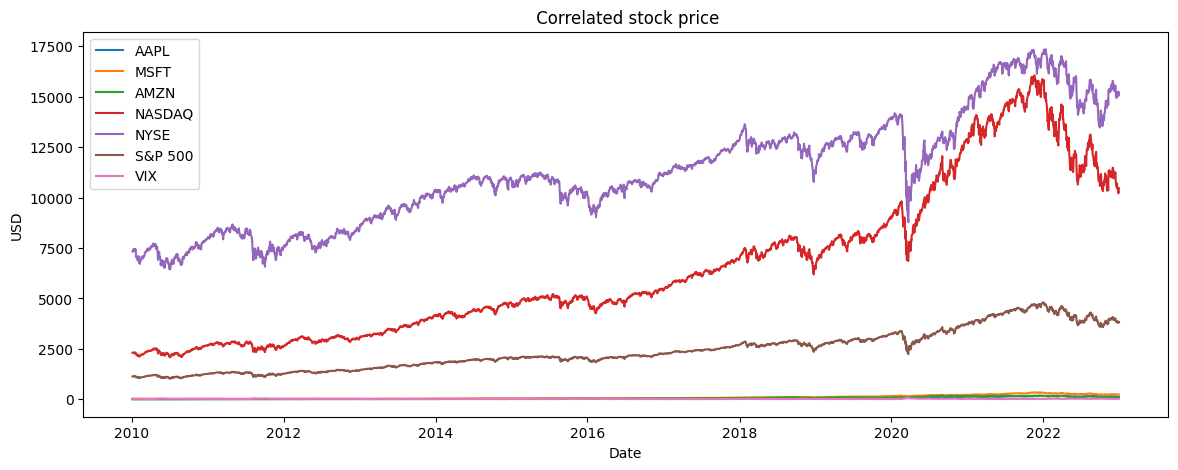

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
for column in close_prices.columns:
    plt.plot(close_prices.index, close_prices[column], label=column)

plt.xlabel('Date')
plt.ylabel('USD')
plt.title(' Correlated stock price')
plt.legend()
plt.show()

In [ ]:
close_prices = close_prices.reset_index()
close_prices_dropped = close_prices.drop(columns=['Date'])

# Concatenate the DataFrames side by side
tickerDf_reset_Cor = pd.concat([tickerDf_reset, close_prices_dropped], axis=1)

# Display the first few rows to verify
tickerDf_reset_Cor.head()

,Date,Open,High,Low,Close,Volume,AAPL,MSFT,AMZN,NASDAQ,NYSE,S&P 500,VIX
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,7.643214,30.950001,6.6950,2308.419922,7326.740234,1132.989990,20.040001
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812,7.656429,30.959999,6.7345,2308.709961,7354.870117,1136.520020,19.350000
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852,7.534643,30.770000,6.6125,2301.090088,7377.700195,1137.140015,19.160000
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,256315428,7.520714,30.450001,6.5000,2300.050049,7393.930176,1141.689941,19.059999
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,188783028,7.570714,30.660000,6.6760,2317.169922,7425.350098,1144.979980,18.129999


In [ ]:
correlated_Assets_Cor = tickerDf_reset_Cor.drop(columns=['Date','Open','High','Low','Volume'])
correlation_matrix = correlated_Assets_Cor.corr()


print(correlation_matrix)


            Close      AAPL      MSFT      AMZN    NASDAQ      NYSE   S&P 500  \
Close    1.000000  0.964910  0.980884  0.943063  0.984270  0.942550  0.980966   
AAPL     0.964910  1.000000  0.983997  0.920145  0.958936  0.882083  0.945344   
MSFT     0.980884  0.983997  1.000000  0.955911  0.977854  0.899146  0.962357   
AMZN     0.943063  0.920145  0.955911  1.000000  0.975444  0.893779  0.948871   
NASDAQ   0.984270  0.958936  0.977854  0.975444  1.000000  0.953882  0.989485   
NYSE     0.942550  0.882083  0.899146  0.893779  0.953882  1.000000  0.981034   
S&P 500  0.980966  0.945344  0.962357  0.948871  0.989485  0.981034  1.000000   
VIX      0.174712  0.276661  0.279264  0.237828  0.167008 -0.040934  0.107244   

              VIX  
Close    0.174712  
AAPL     0.276661  
MSFT     0.279264  
AMZN     0.237828  
NASDAQ   0.167008  
NYSE    -0.040934  
S&P 500  0.107244  
VIX      1.000000  


# Feature Engineering

### Technical indicators
- Captures Trends, Momentum, Volatity, and Trading patterns


1. **7-day and 21-day Moving Averages (ma7 and ma21)**:

 These are simple moving averages calculated over 7 days and 21 days,
respectively.
A moving average smooths out price data by creating a constantly updated average price.
The 7-day moving average will have a shorter "lookback" period and will therefore be more sensitive to recent price changes, while the 21-day moving average will be less sensitive.

2. **MACD (Moving Average Convergence Divergence)**:

 The MACD is calculated by subtracting the 26-day Exponential Moving Average (EMA) from the 12-day EMA.
The 12-day EMA is a faster, more sensitive average, while the 26-day EMA is slower and less sensitive.
The MACD is used to spot changes in the strength, direction, momentum, and duration of a trend in a stock's price.

3. **Bollinger Bands (upper_band and lower_band):**

 Bollinger Bands are a volatility indicator.
The upper band is calculated as a 20-day simple moving average plus twice the 20-day standard deviation of price closes. The lower band is the 20-day moving average minus twice the 20-day standard deviation.
These bands expand when volatility increases and contract when volatility decreases.

4. **Exponential Moving Average (ema):**

 The EMA is similar to the simple moving average, but it gives more weight to recent prices, making it more responsive to new information.
The com=0.5 parameter in the ewm method defines the degree of weighting decrease. A smaller com value means more weight to recent data.
5. **Momentum:**

 The momentum indicator measures the rate of change in stock prices.
In the given code, it's calculated as the current closing price divided by 100, minus 1. This particular formula gives a fractional representation of how much the price has moved relative to a base price of 100.
Momentum is used to identify the strength of a price movement; positive values indicate an upward trend, while negative values indicate a downward trend.

Think about time stamps e.g. days of the week.


In [ ]:

def get_technical_indicators(dataset): #function to generate feature technical indicators


    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()

    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1



    return dataset

In [ ]:
dataset_TI_df = get_technical_indicators(tickerDf_reset_Cor)

dataset_TI_df.head(21)


,Date,Open,High,Low,Close,Volume,AAPL,MSFT,AMZN,NASDAQ,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,7.643214,30.950001,6.6950,2308.419922,...,NaN,NaN,15.684434,15.684434,0.000000,NaN,NaN,NaN,15.684434,-0.843156
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812,7.656429,30.959999,6.7345,2308.709961,...,NaN,NaN,15.648571,15.647022,-0.001550,NaN,NaN,NaN,15.632632,-0.843846
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852,7.534643,30.770000,6.6125,2301.090088,...,NaN,NaN,15.495208,15.481027,-0.014181,NaN,NaN,NaN,15.348156,-0.847783
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,256315428,7.520714,30.450001,6.5000,2300.050049,...,NaN,NaN,15.319691,15.287318,-0.032373,NaN,NaN,NaN,15.023623,-0.851326
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,188783028,7.570714,30.660000,6.6760,2317.169922,...,NaN,NaN,15.260759,15.227069,-0.033689,NaN,NaN,NaN,15.051701,-0.849344
5,2010-01-11,15.126627,15.126627,14.865866,15.042793,288227484,7.503929,30.270000,6.5155,2312.409912,...,NaN,NaN,15.217102,15.182280,-0.034821,NaN,NaN,NaN,15.045754,-0.849572
6,2010-01-12,14.956206,14.968969,14.714715,14.776777,193937868,7.418571,30.070000,6.3675,2282.310059,...,15.182003,NaN,15.138792,15.091794,-0.046999,NaN,NaN,NaN,14.866354,-0.852232
7,2010-01-13,14.426677,14.724224,14.361862,14.691942,259604136,7.523214,30.350000,6.4555,2307.899902,...,15.040219,NaN,15.066794,15.008351,-0.058443,NaN,NaN,NaN,14.750062,-0.853081
8,2010-01-14,14.612112,14.869870,14.584835,14.761011,169434396,7.479643,30.959999,6.3675,2316.739990,...,14.918168,NaN,15.021470,14.959418,-0.062052,NaN,NaN,NaN,14.757362,-0.852390
9,2010-01-15,14.848348,14.853854,14.465465,14.514515,217162620,7.354643,30.860001,6.3570,2287.989990,...,14.817139,NaN,14.951515,14.875109,-0.076406,NaN,NaN,NaN,14.595461,-0.854855


stock price and moving averages

Macd and Momentum



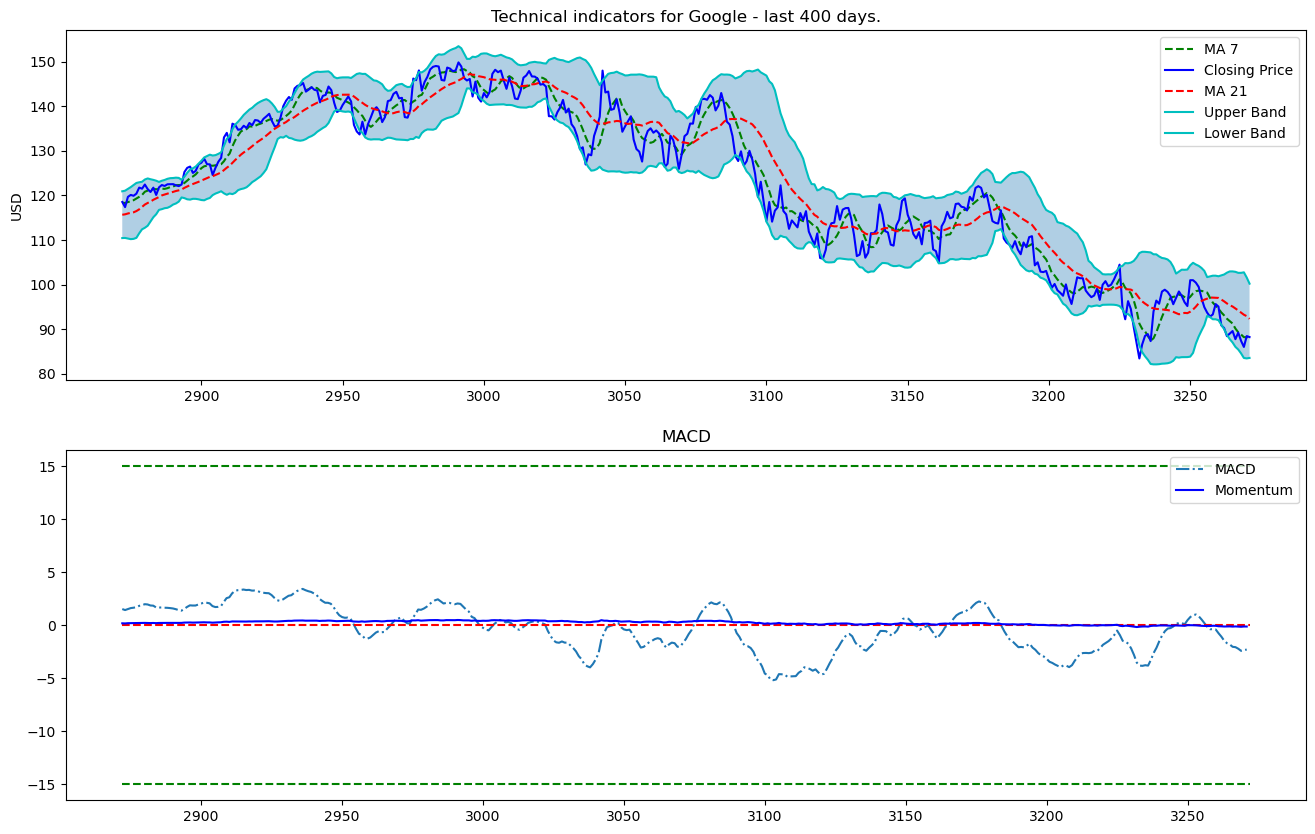

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Google - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(0, xmacd_, shape_0, colors='r', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()


plot_technical_indicators(dataset_TI_df, 400)

**Upper Chart**

- MA7: short term trends

- MA21: medium term trends

- Upper and Lower Bands: bollinger bands, which are volatility indicators.

**Lower Chart**

- MACD: used to identify trends and momentum

- Momentum: measures the rate of change in the stock price

# **Analysis of Time series using Fourier Tranform**

Fourier Transform
- It is a mathematical transform that decomposes functions into frequencies
- applied to decompose the time series into a sum of sine and cosine waves at different frequescies, which represent the underlying cycles in the data.

<Figure size 1400x700 with 0 Axes>

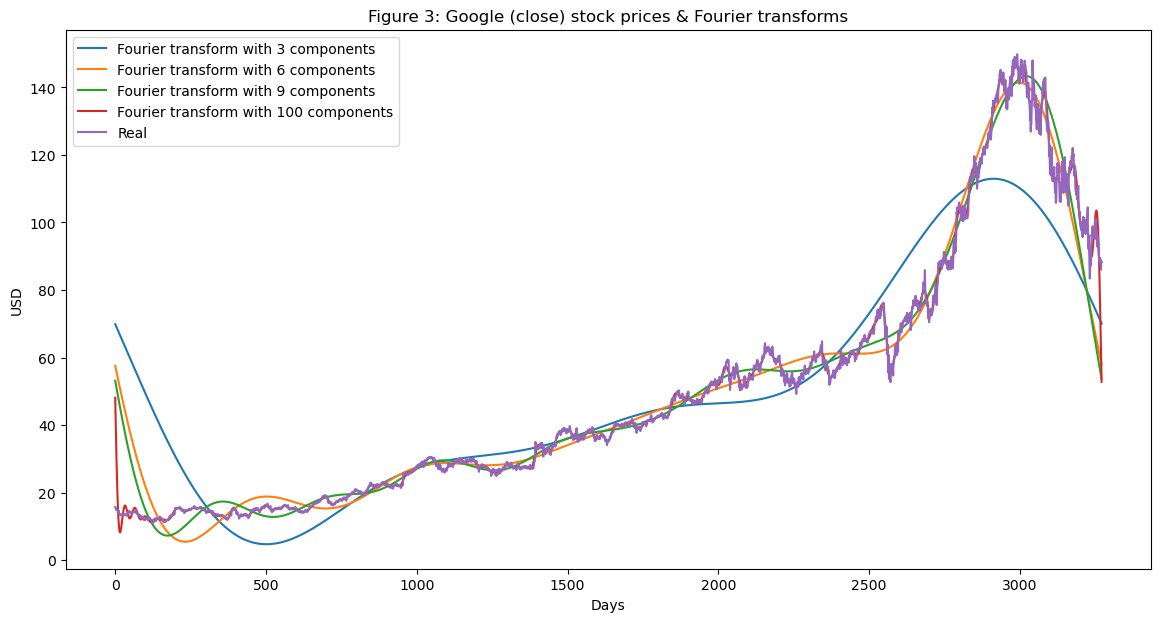

,FFT 3 components,FFT 6 components,FFT 9 components,FFT 100 components
0,69.865004,57.512663,53.134651,48.100355
1,69.661624,57.084550,52.625278,43.523264
2,69.458103,56.657355,52.117532,39.094963
3,69.254445,56.231095,51.611449,34.860985
4,69.050652,55.805791,51.107064,30.862523
5,68.846728,55.381460,50.604414,27.135679
6,68.642676,54.958121,50.103532,23.710849
7,68.438499,54.535793,49.604454,20.612247
8,68.234202,54.114495,49.107214,17.857580
9,68.029786,53.694243,48.611846,15.457879


In [ ]:
data_FT = dataset_TI_df[['Date', 'Close']] # creates a new dataframe
# comutes the Fast fourier Transform (FFT)
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))

# creates a dataframe for the FFT results
fft_df = pd.DataFrame({'fft':close_fft})
# calculates the magnitude of each component in the FFT result.
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
 # calculates phase angle of each component in the FFT result.
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

#dataframe to store reconstructed signals
reconstructed_signals = pd.DataFrame()

# a set of fourier components that will be used to reconstruct the signal
component_nums = [3,6,9,100]
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist()) # converts fft column into an array 'fft_list'


for num_ in component_nums:
    fft_list_m10 = np.copy(fft_list)
    #removes all but num_ lowest frequency components from both ends of the frequency spectrum
    fft_list_m10[num_:-num_] = 0  # Zero out all but the specified components

    #applies the inverse fast fourier which represents the original time series reconstructed
    #using only the remaining non-zero frequency components.
    reconstructed_signal = np.fft.ifft(fft_list_m10)
    # Correctly assign the reconstructed signal to the DataFrame
    reconstructed_signals[f'FFT {num_} components'] = reconstructed_signal.real  # Store only the real part

# Plotting remains the same
plt.figure(figsize=(14, 7), dpi=100)
for num_ in component_nums:
    plt.plot(reconstructed_signals[f'FFT {num_} components'], label=f'Fourier transform with {num_} components')

plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Google (close) stock prices & Fourier transforms')
plt.legend()
plt.show()
reconstructed_signals.head(20)

**Fourier Transform** uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted. Fourier Transform as indicator helps to extract predominate cycle from a series of data



In [ ]:

dataset_FOUR_df = pd.concat([dataset_TI_df, reconstructed_signals], axis=1)


dataset_FOUR_df.head()


,Date,Open,High,Low,Close,Volume,AAPL,MSFT,AMZN,NASDAQ,...,MACD,20sd,upper_band,lower_band,ema,momentum,FFT 3 components,FFT 6 components,FFT 9 components,FFT 100 components
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,7.643214,30.950001,6.6950,2308.419922,...,0.000000,NaN,NaN,NaN,15.684434,-0.843156,69.865004,57.512663,53.134651,48.100355
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,120067812,7.656429,30.959999,6.7345,2308.709961,...,-0.001550,NaN,NaN,NaN,15.632632,-0.843846,69.661624,57.084550,52.625278,43.523264
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,158988852,7.534643,30.770000,6.6125,2301.090088,...,-0.014181,NaN,NaN,NaN,15.348156,-0.847783,69.458103,56.657355,52.117532,39.094963
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,256315428,7.520714,30.450001,6.5000,2300.050049,...,-0.032373,NaN,NaN,NaN,15.023623,-0.851326,69.254445,56.231095,51.611449,34.860985
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,188783028,7.570714,30.660000,6.6760,2317.169922,...,-0.033689,NaN,NaN,NaN,15.051701,-0.849344,69.050652,55.805791,51.107064,30.862523


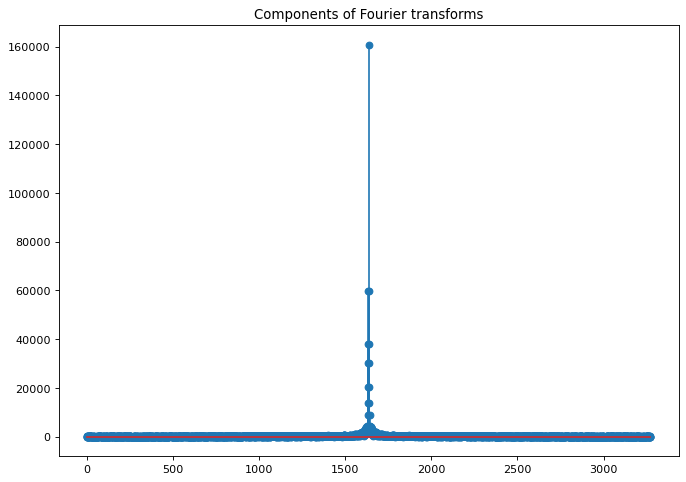

In [ ]:
from collections import deque
#convert the absolute column of fft_df to a numpy array and create a deque from it
items = deque(np.asarray(fft_df['absolute'].tolist()))
#rotate the deque by half the length of fft_df to center the low-frequency components
#this is often done because the fourier transfrom produces symmetric outputs with low frequencies at both ends
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
#creating a stem plot of the fourier transform components
#the stem plot is used to display the magnitude of each component
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

Component analysis of Fourier Transform

Once the spectral part of Fourier transform is removed the magnitude part is quite close to the test series values! Fourier transform is working!

The transform has successfully identified and isolated the significant frequency components of the data, and the inverse transform has produced a signal that closely resembles the original data in its key aspects.

# Data Transformation



For the lag features that intoduce missing values we need to decide how to handle them.

We can drop the rows with a NaN value

In [ ]:
dataset_R_df = dataset_FOUR_df.dropna()
dataset_R_df.reset_index(drop=True, inplace=True)
dataset_R_df.head()

,Date,Open,High,Low,Close,Volume,AAPL,MSFT,AMZN,NASDAQ,...,MACD,20sd,upper_band,lower_band,ema,momentum,FFT 3 components,FFT 6 components,FFT 9 components,FFT 100 components
0,2010-02-02,13.387387,13.387387,13.203453,13.291291,163684152,6.995000,28.459999,5.9060,2190.060059,...,-0.302365,0.755039,15.812893,12.792738,13.305210,-0.867087,65.774365,49.145731,43.295965,9.627760
1,2010-02-03,13.229980,13.566066,13.218969,13.534034,119844036,7.115357,28.629999,5.9550,2190.909912,...,-0.288114,0.706482,15.611713,12.785784,13.457759,-0.864660,65.568790,48.739435,42.825654,10.307092
2,2010-02-04,13.438438,13.463463,13.152152,13.182683,134972892,6.858929,27.840000,5.7970,2125.429932,...,-0.297517,0.698165,15.493127,12.700466,13.274375,-0.868173,65.363139,48.334415,42.357639,11.044926
3,2010-02-05,13.223223,13.350851,13.074575,13.295546,126113760,6.980714,28.020000,5.8695,2141.120117,...,-0.293549,0.695321,15.408848,12.627564,13.288489,-0.867045,65.157416,47.930687,41.891949,11.809157
4,2010-02-08,13.325826,13.563564,13.301552,13.350100,107664228,6.932857,27.719999,5.8415,2126.050049,...,-0.283220,0.664443,15.261319,12.603546,13.329563,-0.866499,64.951624,47.528267,41.428616,12.570176


In [ ]:
print(dataset_R_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'AAPL', 'MSFT',
       'AMZN', 'NASDAQ', 'NYSE', 'S&P 500', 'VIX', 'ma7', 'ma21', '26ema',
       '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum',
       'FFT 3 components', 'FFT 6 components', 'FFT 9 components',
       'FFT 100 components'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle

# Assuming 'df' is your DataFrame with the relevant columns
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
df_scaled = scaler.fit_transform(dataset_R_df[['Open', 'High', 'Low', 'Volume', 'AAPL', 'MSFT',
       'AMZN', 'NASDAQ', 'NYSE', 'S&P 500', 'VIX', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum','FFT 3 components', 'FFT 6 components', 'FFT 9 components',
       'FFT 100 components']])
df_target_scaled = target_scaler.fit_transform(dataset_R_df[['Close']])

# Convert the scaled array back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=['Open', 'High', 'Low', 'Volume', 'AAPL', 'MSFT',
       'AMZN', 'NASDAQ', 'NYSE', 'S&P 500', 'VIX', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum','FFT 3 components', 'FFT 6 components', 'FFT 9 components',
       'FFT 100 components'])
df_target_scaled = pd.DataFrame(df_target_scaled, columns=['Close'])

# Add the scaled data back to your original DataFrame if needed
dataset_R_df[['Open', 'High', 'Low', 'Volume', 'AAPL', 'MSFT',
       'AMZN', 'NASDAQ', 'NYSE', 'S&P 500', 'VIX', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum','FFT 3 components', 'FFT 6 components', 'FFT 9 components',
       'FFT 100 components']] = df_scaled
dataset_R_df[['Close']] = df_target_scaled
dataset_R_df.head()

pickle.dump(target_scaler, open('target_scaler.pkl', 'wb'))


/tmp/ipykernel_49264/2919281540.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_R_df[['Open', 'High', 'Low', 'Volume', 'AAPL', 'MSFT',
/tmp/ipykernel_49264/2919281540.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_R_df[['Close']] = df_target_scaled


In [ ]:
loaded_scaler = pickle.load(open('target_scaler.pkl', 'rb'))
rescaled_data = loaded_scaler.inverse_transform(df_target_scaled)
print(rescaled_data)

[[13.29129124]
 [13.53403378]
 [13.18268299]
 ...
 [86.01999664]
 [88.44999695]
 [88.23000336]]


# Export code

In [ ]:
dataset_R_df.head()

,Date,Open,High,Low,Close,Volume,AAPL,MSFT,AMZN,NASDAQ,...,MACD,20sd,upper_band,lower_band,ema,momentum,FFT 3 components,FFT 6 components,FFT 9 components,FFT 100 components
0,2010-02-02,0.017242,0.016510,0.017037,0.017122,0.264750,0.000777,0.017026,0.002625,0.007037,...,0.516820,0.076044,0.025523,0.015825,0.017140,0.017122,0.564214,0.321353,0.264879,0.000000
1,2010-02-03,0.016119,0.017782,0.017149,0.018869,0.189564,0.001464,0.017557,0.002896,0.007097,...,0.518331,0.070236,0.024099,0.015772,0.018243,0.018869,0.562315,0.318366,0.261424,0.004917
2,2010-02-04,0.017605,0.017052,0.016665,0.016340,0.215510,0.000000,0.015089,0.002023,0.002409,...,0.517334,0.069241,0.023259,0.015132,0.016917,0.016340,0.560416,0.315389,0.257986,0.010258
3,2010-02-05,0.016071,0.016250,0.016103,0.017152,0.200316,0.000695,0.015651,0.002424,0.003532,...,0.517755,0.068901,0.022662,0.014586,0.017019,0.017152,0.558516,0.312421,0.254564,0.015790
4,2010-02-08,0.016803,0.017764,0.017747,0.017545,0.168675,0.000422,0.014714,0.002269,0.002453,...,0.518850,0.065207,0.021618,0.014405,0.017316,0.017545,0.556615,0.309462,0.251160,0.021299


In [ ]:
#file_path = 'C:\\Users\\david\\Downloads\\FYPdataset.csv'  # Corrected path in the writable directory
dataset_R_df.to_csv('./Downloads/FYPdataset1.csv', index = False)
import os
print(os.getcwd())


/home/ds30


In [ ]:
!ls /home/ds30/Downloads

'A CLOSER LOOK AT THE OPTIMIZATION LANDSCAPES.pdf'
'Efficient hyperparameter optimization through model-based.pdf'
'Final report.pdf'
 FYPdataset1.csv
 FYPdataset.csv
 GANsforstockmarketprediction.pdf
 gen_model_3_1_104.h5
'Hyperparameter Optimization of GANs using RL.pdf'
 lstm.pdf
'Metropolis-Hastings Generative Adversarial Networks.pdf'
 NIPS-2014-generative-adversarial-nets-Paper.pdf
'Rainbow: Combining Improvements in Deep Reinforcement Learning.pdf'
 scaler.pkl
 stockmarketpredictionbasedonGAN.pdf
 stockpricepredictionusingGAN.pdf
 target_scaler.pkl
 Technicalindicatorsplot.png
 test_x_slide.pt
 test_y_gan.pt
 test_y_slide.pt
 train_x_slide.pt
 train_y_gan.pt
 train_y_slide.pt
'Wasserstein GAN.pdf'
